In [41]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', 200)
import warnings
from collections import defaultdict
from typing import Any, Dict, Optional, Union
from tqdm import tqdm
from matplotlib.axes import Axes

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("Set2")
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [4]:
dtypes = {
    'session_id': 'category',
    'elapsed_time': np.int32,
    'event_name': 'category',
    'level': np.uint8,
    'text': 'category',
    'level_group': 'category'
}
cols_to_use = ['session_id', 'index', 'elapsed_time', 'event_name', 'level', 'text', 'level_group']
eda_df = pd.read_csv("/Users/macintosh/Desktop/data_completitions/Kaggle/2023/predict-student-performance-from-game-play/train.csv", usecols=cols_to_use, dtype=dtypes)

In [5]:
# Set level colour
N_SESS = eda_df['session_id'].nunique()
LEVELS = range(23)
LV_COLORS = plt.cm.get_cmap('hsv', len(LEVELS))

In [4]:
pk_temp = ['session_id', 'index']
# eda_df.loc[eda_df.duplicated(subset=pk_temp)].groupby('session_id').index.count().sort_values(ascending=False).head()
assert not eda_df.duplicated(subset=pk_temp).any()

AssertionError: 

In [5]:
# Duplicate Session ID, Index pair
sess_dup = eda_df.loc[eda_df.duplicated(subset=pk_temp, keep=False)].session_id.unique().tolist()
eda_dup = eda_df[eda_df.session_id.isin(sess_dup)].reset_index(drop=True)
print(f'Session id pair duplicate is : {len(sess_dup)}')

Session id pair duplicate is : 142


In [6]:
# n_rows, n_cols = 29, 5
# fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 80))
# # Group df to each session_id by eda_dup.groupby('session_id', observed=True)
# # Use enumerate to get index
# for i, (session_id, gp) in enumerate(eda_dup.groupby('session_id', observed=True)):
#     gp = gp.reset_index(drop=True)
#     # Use to find axis x, y for create graph
#     axis[i // n_cols, i % n_cols].plot(gp['index'])
#     axis[i // n_cols, i % n_cols].set_title(f'Even Index of Session {session_id}\n Min Index {gp["index"].min()}')
#     axis[i // n_cols, i % n_cols].set_xlabel(f'Event Ordering in DataFrame')
#     axis[i // n_cols, i % n_cols].set_ylabel(f'Event Index')
#     plt.tight_layout()

In [8]:
# Reverse Index
session_with_reversed_index = []
for session_id, gp in eda_df.groupby('session_id', observed=True):
    if not gp['index'].is_monotonic_increasing:
        session_with_reversed_index.append(session_id)
print(f'Not monotonic increase session: {len(session_with_reversed_index)}')

Not monotonic increase session: 258


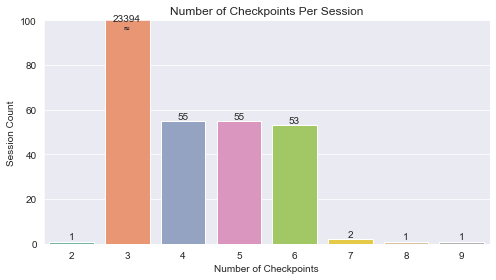

In [9]:
n_ckpts_per_sess = eda_df.groupby(["session_id", "level_group"]).apply(lambda x: (x["event_name"] == "checkpoint").sum()).reset_index()
n_ckpts_per_sess = n_ckpts_per_sess.pivot(index="session_id", columns="level_group", values=0)

n_ckpts_per_sess["total"] = n_ckpts_per_sess["0-4"] + n_ckpts_per_sess["5-12"] + n_ckpts_per_sess["13-22"]
n_ckpts_per_sess_val_cnt = n_ckpts_per_sess["total"].value_counts()

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x=n_ckpts_per_sess_val_cnt.index, y=n_ckpts_per_sess_val_cnt.values, 
            palette=colors, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Number of Checkpoints Per Session")
ax.set_xlabel("Number of Checkpoints")
ax.set_ylabel("Session Count")
ax.set_ylim([0, 100])
ax.text(0.98, 95, f"{n_ckpts_per_sess_val_cnt[n_ckpts_per_sess_val_cnt.index == 3].values[0]}\n≈", horizontalalignment="center")
plt.tight_layout()

In [11]:
# Abnormal Game Play
ckpt_valid_mask = (n_ckpts_per_sess["0-4"] == 1) & (n_ckpts_per_sess["5-12"] == 1) & (n_ckpts_per_sess["13-22"] == 1)
sess_with_invalid_ckpt = n_ckpts_per_sess.loc[~ckpt_valid_mask].index.astype(int).tolist()
print(f"There are {len(sess_with_invalid_ckpt)} sessions with less than or more than 3 checkpoints.")

There are 168 sessions with less than or more than 3 checkpoints.


In [39]:
def plot_level_with_ckpt(sess_id: int, ax: Optional[Axes] = None) -> None:
    """Plot level sequence of the specified session.
    
    Parameters:
        sess_id: session identifier
    
    Return:
        None
    """
    plot = False
    sess = eda_df[eda_df["session_id"] == sess_id].reset_index(drop=True)
    ckpts = sess[sess["event_name"] == "checkpoint"].index
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2))
        plot = True
    for i, lv in enumerate(LEVELS):
        lv_seq = sess[sess["level"] == lv]["level"]
        # ax.scatter(lv_seq.index.values, lv_seq.values, 0.8, marker="_", c=LV_COLORS(i), linewidths=2)
        ax.scatter(lv_seq.index.values, lv_seq.values, 0.8, c=LV_COLORS(i), linewidths=2) # axis X for index & Y for level
    for ckpt in ckpts:
        ax.axvline(ckpt, linestyle="--", linewidth=.7, color="g")
    ax.set_title(f"Level Seq of {sess_id}", fontsize=12)

    if plot:
        plt.show()


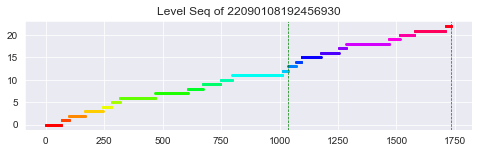

In [42]:
eda_df["session_id"] = eda_df["session_id"].astype(int)
plot_level_with_ckpt(22090108192456930)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

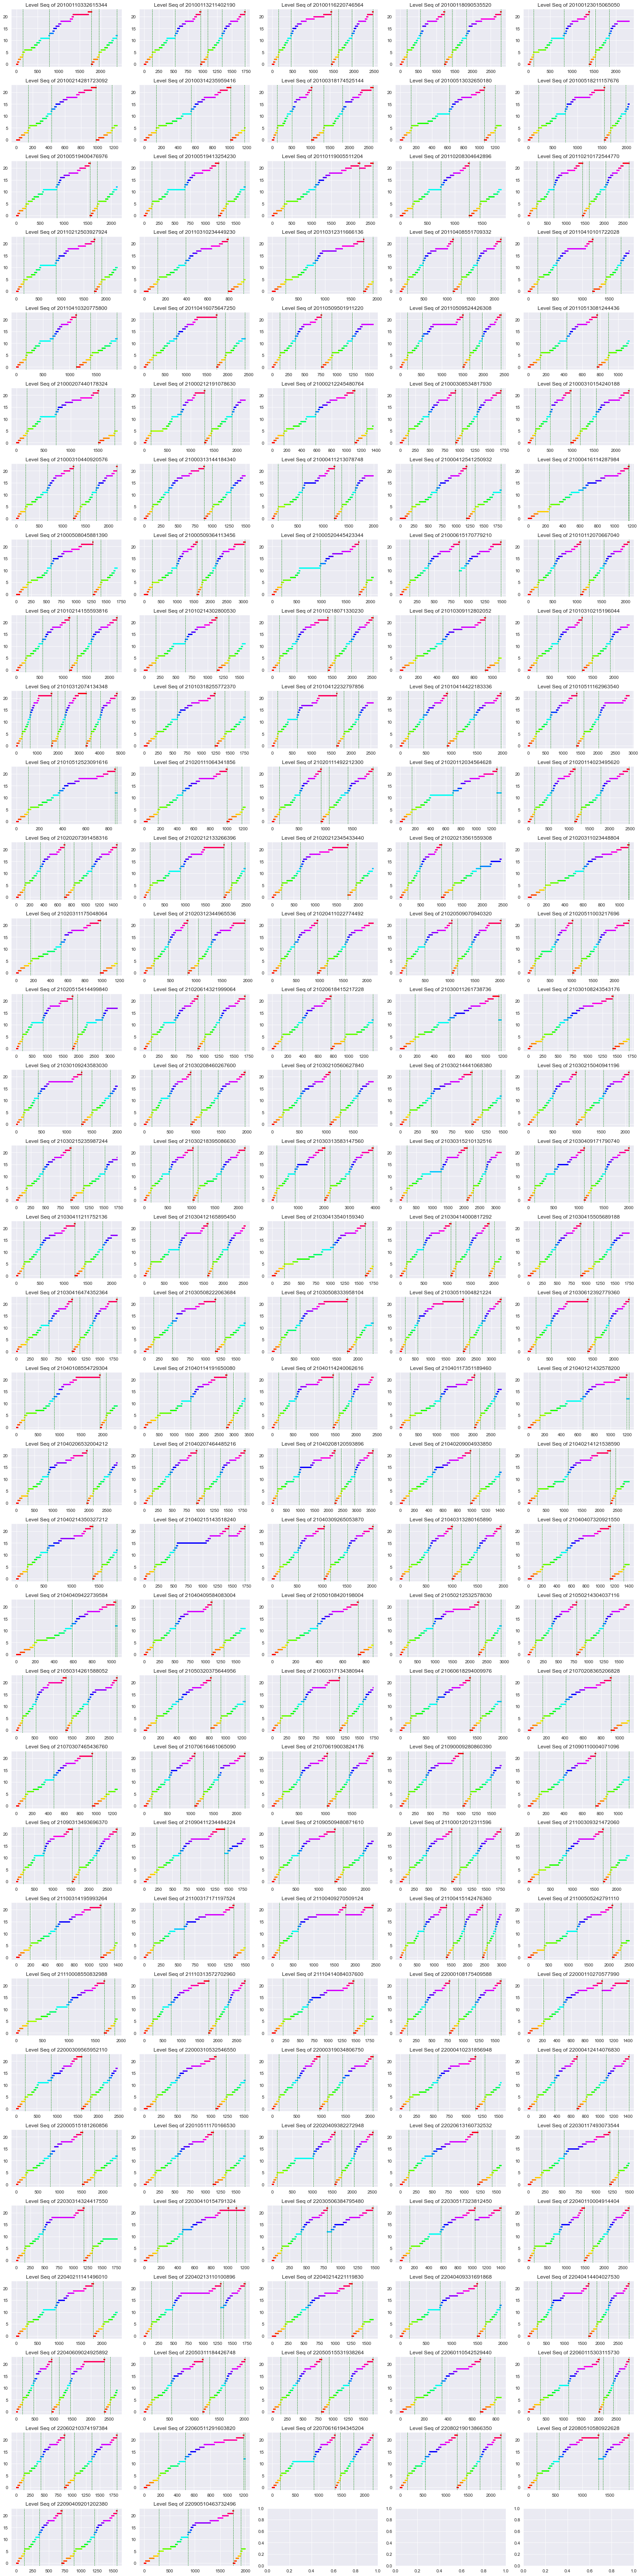

In [18]:
sess_with_invalid_ckpt.remove(22090108192456930)

fig, axes = plt.subplots(nrows=34, ncols=5, figsize=(20, 80))
for i, sess_id in enumerate(sess_with_invalid_ckpt):
    plot_level_with_ckpt(sess_id, ax=axes[i // 5, i % 5])
plt.tight_layout()